# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1030s1"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1310, 32, 20, 3)
(1310, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 64)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
328/328 [==============================] - 3s 7ms/step - loss: 2.1938 - accuracy: 0.3316
Epoch 2/500
328/328 [==============================] - 3s 8ms/step - loss: 1.2489 - accuracy: 0.6158
Epoch 3/500
328/328 [==============================] - 3s 9ms/step - loss: 0.8569 - accuracy: 0.7412
Epoch 4/500
328/328 [==============================] - 3s 9ms/step - loss: 0.7476 - accuracy: 0.7668
Epoch 5/500
328/328 [==============================] - 3s 9ms/step - loss: 0.6189 - accuracy: 0.8018: 1s - loss: 0.6158 - ac - ETA: 0s - los
Epoch 6/500
328/328 [==============================] - 3s 9ms/step - loss: 0.6498 - accuracy: 0.8309
Epoch 7/500
328/328 [==============================] - 3s 9ms/step - loss: 0.6068 - accuracy: 0.8195
Epoch 8/500
328/328 [==============================] - 3s 9ms/step - loss: 0.4917 - accuracy: 0.8545
Epoch 9/500
328/328 [==============================] - 3s 10ms/step - loss: 0.3476 - accuracy: 0.8860
Epoch 10/500
328/328 [============================

328/328 [==============================] - 3s 10ms/step - loss: 0.1157 - accuracy: 0.9697
Epoch 80/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0620 - accuracy: 0.9787
Epoch 81/500
328/328 [==============================] - 3s 10ms/step - loss: 0.1149 - accuracy: 0.9779
Epoch 82/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0369 - accuracy: 0.9906
Epoch 83/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0580 - accuracy: 0.9781
Epoch 84/500
328/328 [==============================] - 3s 9ms/step - loss: 0.1243 - accuracy: 0.9693
Epoch 85/500
328/328 [==============================] - 3s 10ms/step - loss: 0.1016 - accuracy: 0.9752
Epoch 86/500
328/328 [==============================] - 3s 10ms/step - loss: 0.1092 - accuracy: 0.9745
Epoch 87/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0626 - accuracy: 0.9851 0s - l
Epoch 88/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0

328/328 [==============================] - 3s 10ms/step - loss: 0.0667 - accuracy: 0.9871
Epoch 158/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0736 - accuracy: 0.9836
Epoch 159/500
328/328 [==============================] - 3s 9ms/step - loss: 0.0433 - accuracy: 0.9931
Epoch 160/500
328/328 [==============================] - 3s 9ms/step - loss: 0.0126 - accuracy: 0.9952
Epoch 161/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0363 - accuracy: 0.9923
Epoch 162/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0624 - accuracy: 0.9856
Epoch 163/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0325 - accuracy: 0.9931
Epoch 164/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0370 - accuracy: 0.9907
Epoch 165/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0416 - accuracy: 0.9872
Epoch 166/500
328/328 [==============================] - 3s 10ms/step - loss: 0.

328/328 [==============================] - 3s 10ms/step - loss: 0.0285 - accuracy: 0.9918
Epoch 236/500
328/328 [==============================] - 3s 9ms/step - loss: 0.0237 - accuracy: 0.9912
Epoch 237/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0332 - accuracy: 0.9936
Epoch 238/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0204 - accuracy: 0.9946
Epoch 239/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0143 - accuracy: 0.9958 0s - loss: 0.0125 - accu - ETA: 0s - loss: 0.0134 - ac
Epoch 240/500
328/328 [==============================] - 4s 11ms/step - loss: 0.0590 - accuracy: 0.9840
Epoch 241/500
328/328 [==============================] - 4s 11ms/step - loss: 0.0230 - accuracy: 0.9930
Epoch 242/500
328/328 [==============================] - 4s 12ms/step - loss: 0.0277 - accuracy: 0.9951
Epoch 243/500
328/328 [==============================] - 4s 12ms/step - loss: 0.0304 - accuracy: 0.9908 
Epoch 244/500
328/328 [

328/328 [==============================] - 4s 11ms/step - loss: 0.0301 - accuracy: 0.9924
Epoch 313/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0215 - accuracy: 0.9923
Epoch 314/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0375 - accuracy: 0.9924
Epoch 315/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0168 - accuracy: 0.9971
Epoch 316/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0209 - accuracy: 0.9955
Epoch 317/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0272 - accuracy: 0.9942
Epoch 318/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0048 - accuracy: 0.9988
Epoch 319/500
328/328 [==============================] - 4s 11ms/step - loss: 0.0483 - accuracy: 0.9875
Epoch 320/500
328/328 [==============================] - 4s 11ms/step - loss: 0.0182 - accuracy: 0.9902
Epoch 321/500
328/328 [==============================] - 3s 10ms/step - loss: 

328/328 [==============================] - 4s 11ms/step - loss: 0.0145 - accuracy: 0.9939
Epoch 390/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0472 - accuracy: 0.9913
Epoch 391/500
328/328 [==============================] - ETA: 0s - loss: 0.0252 - accuracy: 0.99 - 3s 10ms/step - loss: 0.0255 - accuracy: 0.9927
Epoch 392/500
328/328 [==============================] - 3s 11ms/step - loss: 0.0207 - accuracy: 0.9943
Epoch 393/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0103 - accuracy: 0.9974 0s - loss:
Epoch 394/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0094 - accuracy: 0.9954
Epoch 395/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0114 - accuracy: 0.9958
Epoch 396/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0158 - accuracy: 0.9959
Epoch 397/500
328/328 [==============================] - 3s 10ms/step - loss: 0.0320 - accuracy: 0.9958
Epoch 398/500
328/328 [==

328/328 [==============================] - 2s 7ms/step - loss: 0.0318 - accuracy: 0.9888
Epoch 467/500
328/328 [==============================] - 2s 7ms/step - loss: 0.0289 - accuracy: 0.9950
Epoch 468/500
328/328 [==============================] - 2s 7ms/step - loss: 0.0238 - accuracy: 0.9943
Epoch 469/500
328/328 [==============================] - 3s 8ms/step - loss: 0.0139 - accuracy: 0.9922
Epoch 470/500
328/328 [==============================] - 2s 7ms/step - loss: 0.0279 - accuracy: 0.9925
Epoch 471/500
328/328 [==============================] - 2s 8ms/step - loss: 0.0034 - accuracy: 0.9988
Epoch 472/500
328/328 [==============================] - 2s 8ms/step - loss: 0.0212 - accuracy: 0.9958
Epoch 473/500
328/328 [==============================] - 2s 7ms/step - loss: 0.0139 - accuracy: 0.9923
Epoch 474/500
328/328 [==============================] - 2s 8ms/step - loss: 0.0307 - accuracy: 0.9935
Epoch 475/500
328/328 [==============================] - 2s 7ms/step - loss: 0.0169 - a

### Learing result
 
* Visualization of the training and validation results

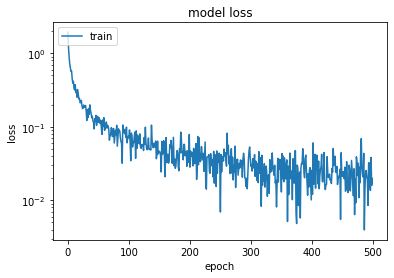

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

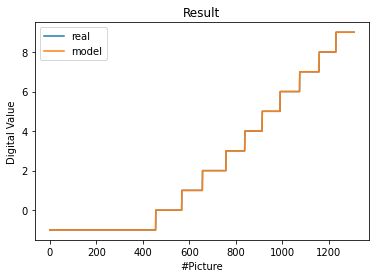

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmphaahmq82\assets


766432

In [8]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 20, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp_ozcwfr0\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp_ozcwfr0\assets


203200

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.